# Install and import packages 

In [1]:
%%python -m pip install poreana
%%python -m pip install porems

In [1]:
import poreana as pa
import porems as pms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets



# Overview 
The data set contains the following systems at a Temperature $T=295 K$:

|Alcohol   |Aromatic|Alkene      |
|:---------|:-------|:-----------|
|Methanol  |Benzene |Cyclopentane|
|Ethanol   |Toluene |Cyclohexane |
|1-Propanol|Pyrole  |Hexane      |
|1-Butanol |Pyridine|Heptane     |




Set strings to the files in the data verse

In [3]:
drop = widgets.Dropdown(
    options=['methanol', 'ethanol', '1-propanol'],
    value="methanol",
    description='Molecule:',
    disabled=False,
)


display(drop)




Dropdown(description='Molecule:', options=('methanol', 'ethanol', '1-propanol'), value='methanol')

In [4]:
molecule = drop.value

strings = {}
# Strcuture for molecule
strings["gro_mol"] = "Molecules/{}/{}.gro".format(molecule,molecule)

# Strings for pure rectangular systems
strings["dens_box"] = "Pure/{}/box_rectangular_{}_density.h5".format(molecule,molecule)
strings["mc_box"] = "Pure/{}/box_rectangular_{}_diffusion_smoluchowski.h5".format(molecule,molecule)
# Strings for pore system
strings["dens"] = "Pore/{}/pore_ideal_{}_density.h5".format(molecule,molecule)
strings["bin"] = "Pore/{}/pore_ideal_{}_diffusion_einstein.h5".format(molecule,molecule)
strings["mc"] = "Pore/{}/pore_ideal_{}_diffusion_smoluchowski.h5".format(molecule,molecule)

#Strcuture for pore system
strings["gro_pore"] = "Molecules/{}/pore_ideal_{}.gro".format(molecule,molecule)

# Strings for amoprh pore systems (if exisit)
if molecule in ["cyclopentane","hexane","heptan"]:
    strings["dens"] = "Pore/{}/pore_amorph_{}_density.h5".format(molecule,molecule)
    strings["bin"] = "Pore/{}/pore_amorph_{}_diffusion_einstein.h5".format(molecule,molecule)
    strings["mc"] = "Pore/{}/pore_amorph_{}_diffusion_smoluchowski.h5".format(molecule,molecule)
    


# Molecule and Pore

In [3]:
import nglview as nv

AttributeError: 'super' object has no attribute '_ipython_display_'

In [2]:
import MDAnalysis as mda
import nglview as nv
mol = mda.Universe(strings["gro_mol"])
view = nv.show_mdanalysis(mol)
view.display()



AttributeError: 'super' object has no attribute '_ipython_display_'

# Density

In [6]:
dens = pa.density.bins(strings["dens"], is_print=False)
plt.plot(dens["sample"]["data"]["in_width"][:-1],[den for den in dens["num_dens"]["in"]], label = )
plt.plot(dens["sample"]["data"]["ex_width"][:-1],[dens["mean"]["ex"] for i in dens["num_dens"]["ex"][:-1]], linestyle = "--")
plt.axvspan(xmin=2.1, xmax=2.5, facecolor="grey", alpha=0.3, label= "Sinanol O")
plt.ylabel("Density (molecules $\mathrm{nm}^{-1}$)")
plt.xlabel("Distance from pore center (nm)")
plt.title(molecule)
plt.legend()
plt.xlim([0,2.5])

SyntaxError: invalid syntax (2646891978.py, line 2)

# Diffusion

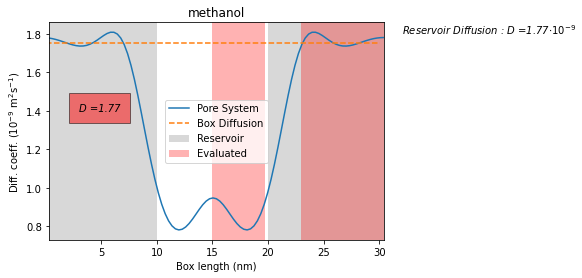

In [ ]:
mc_box = pa.diffusion.mc_fit(strings["mc_box"], len_step = [10,20,30,40,50,60], is_plot=False, is_print=False)
mc_pore = pa.diffusion.mc_profile(strings["mc"], len_step = [10,20,30,40,50,60], kwargs={"label": "Pore System"})
res = pa.diffusion.mc_fit(strings["mc"], len_step = [10,20,30,40,50,60], section = [0,7], is_plot=False, is_print=False)
sns.lineplot(x=np.linspace(0,30.1,100),y=[mc_box[0] for i in range(100)], linestyle="--", label="Box Diffusion")
plt.title(molecule)
plt.text(3, 1.4, 'D =' + "%.2f" % (res[0])  , style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.text(32, 1.8 , 'Reservoir Diffusion : D =' + "%.2f" % (res[0]) +"$\\cdot 10^{-9}$"  , style='italic',
        )
# Plot area
plt.axvspan(xmin=0, xmax=10, facecolor="grey", alpha=0.3, label = "Reservoir")
plt.axvspan(xmin=20, xmax=31, facecolor="grey", alpha=0.3)
plt.axvspan(xmin=15, xmax=19.7, facecolor="red", alpha=0.3, label = "Evaluated")
plt.axvspan(xmin=23, xmax=31, facecolor="red", alpha=0.3)
plt.legend()